# AI Query Tube

## 1. Setup and Imports

In [39]:
%pip install youtube-transcript-api sentence-transformers tf-keras

import os
import sys
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api._errors import TranscriptsDisabled, NoTranscriptFound, VideoUnavailable
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

Note: you may need to restart the kernel to use updated packages.


## 2. YouTube Data Collection

In [40]:
API_KEY = os.environ.get('YOUTUBE_API_KEY')
if API_KEY is None:
    raise RuntimeError('Set YOUTUBE_API_KEY in the environment before running this notebook')
CHANNEL_ID = "UC4SVo0Ue36XCfOyb5Lh1viQ"

In [45]:
url = "https://www.googleapis.com/youtube/v3/search"
params = {
    "key": API_KEY,
    "channelId": CHANNEL_ID,
    "part": "snippet,id",
    "order": "date",
    "maxResults": 50,
    "hl": "en",
    "regionCode": "US"
}

def extract_video_fields(item):
    video_id = item["id"]["videoId"]
    title = item["snippet"]["title"]
    published = item["snippet"]["publishedAt"]
    return video_id, title, published 

videos = []
next_page_token = None


# Set a limit of pages to fetch to avoid infinite loops if something goes wrong, or remove for full channel


videos = []
next_page_token = None

while True:
    if next_page_token:
        params["pageToken"] = next_page_token

    try:
        resp = requests.get(url, params=params, timeout=10)
        resp.raise_for_status()
        data = resp.json()
    except Exception as e:
        print("Request failed:", e)
        break

    for item in data.get("items", []):
        if "videoId" in item.get("id", {}):
            video_id, title, published = extract_video_fields(item)
            videos.append([video_id, title, published])

    next_page_token = data.get("nextPageToken")

    if not next_page_token:
        break


df = pd.DataFrame(videos, columns=["video_id", "title", "published_date"])
df.to_csv("youtube_metadata.csv", index=False)
display(df.head())


,video_id,title,published_date
0,fPopFeqw5sk,Learn NumPy data types in 8 minutes! 💱,2025-11-21T15:40:45Z
1,xf71dRBRP6o,Build a music player with Python! 🎶,2025-11-20T16:51:00Z
2,k0D3MQwLn7A,Learn Python iterators in 7 minutes! ➡️,2025-11-10T14:21:48Z
3,ZBlxaXMN_hU,Learn Python generator expressions in 9 minute...,2025-11-07T15:08:16Z
4,c9vhHUGdav0,Learn Matplotlib in 1 hour! 📊,2025-10-09T14:01:03Z


In [46]:
df = pd.DataFrame(videos, columns=["video_id", "title", "published_date"])

print("Total videos fetched:", len(df))
assert len(df) >= 80, "Too few videos fetched — semantic search will not work"

df.to_csv("youtube_metadata.csv", index=False)
display(df.head())


Total videos fetched: 215


,video_id,title,published_date
0,fPopFeqw5sk,Learn NumPy data types in 8 minutes! 💱,2025-11-21T15:40:45Z
1,xf71dRBRP6o,Build a music player with Python! 🎶,2025-11-20T16:51:00Z
2,k0D3MQwLn7A,Learn Python iterators in 7 minutes! ➡️,2025-11-10T14:21:48Z
3,ZBlxaXMN_hU,Learn Python generator expressions in 9 minute...,2025-11-07T15:08:16Z
4,c9vhHUGdav0,Learn Matplotlib in 1 hour! 📊,2025-10-09T14:01:03Z


## 3. Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        215 non-null    object
 1   title           215 non-null    object
 2   published_date  215 non-null    object
dtypes: object(3)
memory usage: 5.2+ KB


None

,video_id,title,published_date
count,215,215,215
unique,215,215,215
top,fPopFeqw5sk,Learn NumPy data types in 8 minutes! 💱,2025-11-21T15:40:45Z
freq,1,1,1


Missing values:
video_id          0
title             0
published_date    0
dtype: int64


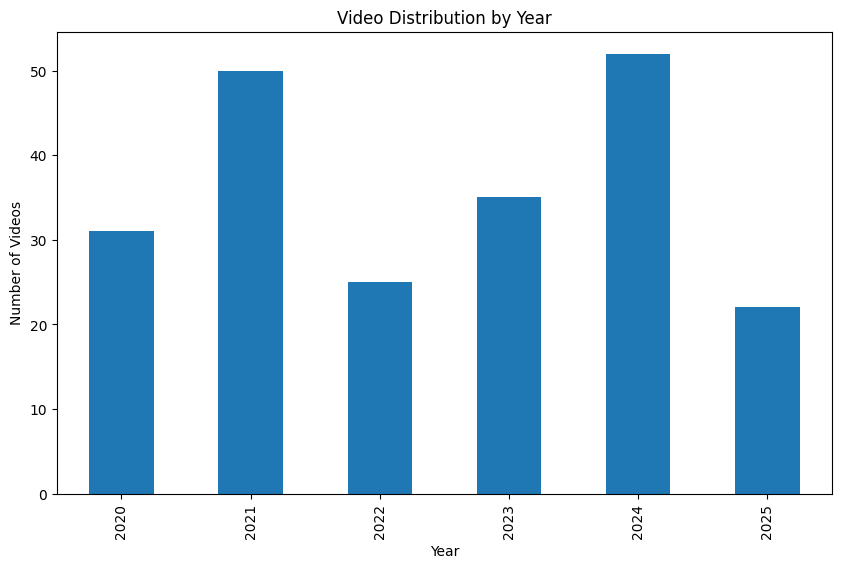

In [20]:
# Basic info
display(df.info())
display(df.describe())

# Missing values
print("Missing values:")
print(df.isnull().sum())

# Publish date distribution
df['published_date'] = pd.to_datetime(df['published_date'])
plt.figure(figsize=(10, 6))
df['published_date'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Video Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Number of Videos')
plt.show()

## 4. Transcript Extraction and Text Cleaning

In [2]:

# import pandas as pd
# import time
# from youtube_transcript_api import YouTubeTranscriptApi

# # Load existing CSV (IMPORTANT)
# df = pd.read_csv("youtube_metadata.csv")

# # If transcript column doesn't exist, create it
# if "transcript" not in df.columns:
#     df["transcript"] = None

# ytt_api = YouTubeTranscriptApi()
# LIMIT = 10
# DELAY = 1.0

# # Fetch transcripts only for first 10 videos
# for idx, vid in enumerate(df["video_id"].head(LIMIT)):
#     try:
#         transcript_object = ytt_api.fetch(vid)

#         text = " ".join(
#             snippet.text for snippet in transcript_object.snippets
#         )

#         # 🔥 Update ONLY that row
#         df.loc[idx, "transcript"] = text
#         print(f"✅ Success ({idx+1}/{LIMIT}): {vid}")

#     except Exception as e:
#         df.loc[idx, "transcript"] = None
#         print(f"❌ Failed ({idx+1}/{LIMIT}): {vid} | {type(e).__name__}")

#     time.sleep(DELAY)

# # Save back to SAME file (safe overwrite)
# df.to_csv("youtube_metadata.csv", index=False)

# print("🎉 Transcript column updated for top 10 videos")

# # Preview
# df.head(12)


import pandas as pd
import time
from youtube_transcript_api import YouTubeTranscriptApi

# Load metadata
df = pd.read_csv("youtube_metadata.csv")

# Ensure transcript column exists
if "transcript" not in df.columns:
    df["transcript"] = None

ytt_api = YouTubeTranscriptApi()
DELAY = 1.0

success = 0
fail = 0

# 🔥 FETCH TRANSCRIPTS FOR ALL VIDEOS
for idx, vid in enumerate(df["video_id"]):
    try:
        transcript_object = ytt_api.fetch(vid)

        text = " ".join(
            snippet.text for snippet in transcript_object.snippets
        )

        df.loc[idx, "transcript"] = text
        success += 1
        print(f"✅ Success ({success}): {vid}")

    except Exception as e:
        df.loc[idx, "transcript"] = None
        fail += 1
        print(f"❌ Failed ({fail}): {vid} | {type(e).__name__}")

    time.sleep(DELAY)

# SAVE FULL DATASET
df.to_csv("youtube_metadata.csv", index=False)

print(f"🎉 Done | Success: {success} | Failed: {fail}")
print("Total rows:", len(df))


✅ Success (1): fPopFeqw5sk
✅ Success (2): xf71dRBRP6o
✅ Success (3): k0D3MQwLn7A
✅ Success (4): ZBlxaXMN_hU
✅ Success (5): c9vhHUGdav0
✅ Success (6): OUnnuKHbmbU
✅ Success (7): 6WaBryk4fkE
✅ Success (8): mjiHc965UME
✅ Success (9): sHrlK5tOGpw
✅ Success (10): tg5Wv9Ba1lI
✅ Success (11): J6qXny_UAK4
✅ Success (12): ZwSyuqbeN0c
✅ Success (13): rUXjvybSPWc
✅ Success (14): eIlcl-mt3tg
✅ Success (15): Jx12Vf0VxmY
✅ Success (16): y4siEcxgOpM
✅ Success (17): 6Hk2aE_SRzY
✅ Success (18): Z5smVeUVNFU
✅ Success (19): zdAggA1q0eo
✅ Success (20): NEj2H7SoTzQ
✅ Success (21): NtlSzRWhaOc
✅ Success (22): wt194lO5kKE
✅ Success (23): taI7G6U29L8
✅ Success (24): P_iOnmdww8E
✅ Success (25): Pg0aoSbrqOE
✅ Success (26): wsTSREgCE5E
❌ Failed (1): OjrR_C_UPjc | TranscriptsDisabled
✅ Success (27): hx_DRanBRRM
✅ Success (28): ZD7CB6wKg8A
✅ Success (29): LN45TyPWAAg
✅ Success (30): DYbi93vuSaU
✅ Success (31): Qf3Nczxm2AY
✅ Success (32): ah5bAnGpmKY
✅ Success (33): 9dr2mHYYoug
✅ Success (34): iGo1Syv4YuM
✅ Success

In [4]:
df.to_csv("youtube_metadata.csv", index=False)

In [3]:
print("Total videos:", len(df))
print("Videos with transcript:", df["transcript"].notna().sum())

assert df["transcript"].notna().sum() >= 50, \
    "Too few transcripts — semantic search will fail"



Total videos: 215
Videos with transcript: 211


## 5. Embeddings and Search

In [8]:
model = SentenceTransformer("all-MiniLM-L6-v2")

df["text_for_embedding"] = df["title"] + " " + df["transcript"].fillna("")
df["embedding"] = df["text_for_embedding"].apply(lambda x: model.encode(x))

c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [9]:
query = "c++ tutorails"

query_embedding = model.encode(query)

scores = cosine_similarity([query_embedding], list(df["embedding"]))
top_idx = scores[0].argsort()[-5:][::-1]  # Top 5 results

results = df.iloc[top_idx][["title", "video_id"]].copy()
results["score"] = scores[0][top_idx]
display(results)

c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,title,video_id,score
127,C++ Full Course for free ⚡️,-TkoO8Z07hI,0.461847
214,C++ if statements (#6) ❓,ljEZlKU5XT4,0.448486
168,C# classes 📦,9V5B3dNoVIA,0.424775
133,How to accept user input in C++? ⌨️,imiIhu9u670,0.381812
141,C pointers explained👉,DplxIq0mc_Y,0.374830


In [7]:
!pip install -q sentence-transformers scikit-learn pandas numpy
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist


c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv("youtube_metadata.csv")

df = df.dropna(subset=["transcript"]).reset_index(drop=True)

df.head()


,video_id,title,published_date,transcript
0,fPopFeqw5sk,Learn NumPy data types in 8 minutes! 💱,2025-11-21T15:40:45Z,"Yo, hello again everybody. In this video, I'm ..."
1,xf71dRBRP6o,Build a music player with Python! 🎶,2025-11-20T16:51:00Z,"What is going on everybody? In this video, I t..."
2,k0D3MQwLn7A,Learn Python iterators in 7 minutes! ➡️,2025-11-10T14:21:48Z,"Hey, what is going on everybody? In this video..."
3,ZBlxaXMN_hU,Learn Python generator expressions in 9 minute...,2025-11-07T15:08:16Z,"All right, everybody. In this video, I'm going..."
4,c9vhHUGdav0,Learn Matplotlib in 1 hour! 📊,2025-10-09T14:01:03Z,"Hey everybody. In this video, I'm going to tea..."


In [ ]:
df["combined_text"] = df["title"] + " " + df["transcript"]


In [6]:
models = {
    "all-MiniLM-L6-v2": SentenceTransformer("all-MiniLM-L6-v2"),
    "paraphrase-MiniLM-L6-v2": SentenceTransformer("paraphrase-MiniLM-L6-v2"),
    "all-mpnet-base-v2": SentenceTransformer("all-mpnet-base-v2")
}


In [7]:
queries = [
    "how to learn python",
    "machine learning basics",
    "deep learning tutorial",
    "data science roadmap",
    "neural networks explained"
]


In [8]:
def evaluate_ranking(distances, correct_index):
    ranking = np.argsort(distances)
    rank = np.where(ranking == correct_index)[0][0] + 1
    
    return {
        "rank": rank,
        "top_1": int(rank == 1),
        "top_3": int(rank <= 3)
    }


In [9]:
results = []

for model_name, model in models.items():
    print(f"Evaluating model: {model_name}")
    
    video_embeddings = model.encode(
        df["combined_text"].tolist(),
        show_progress_bar=True
    )
    
    query_embeddings = model.encode(
        queries,
        show_progress_bar=True
    )
    
    for metric in [ "cosine","euclidean", "cityblock", "chebyshev"]:

        
        if metric == "cosine":
            distance_matrix = 1 - cosine_similarity(query_embeddings, video_embeddings)
        else:
            distance_matrix = cdist(query_embeddings, video_embeddings, metric)
        
        ranks = []
        top1 = []
        top3 = []
        
        for i in range(len(queries)):
            correct_index = i % len(df)  # proxy mapping
            eval_result = evaluate_ranking(distance_matrix[i], correct_index)
            
            ranks.append(eval_result["rank"])
            top1.append(eval_result["top_1"])
            top3.append(eval_result["top_3"])
        metric_name = "manhattan" if metric == "cityblock" else metric

        results.append({
                "model": model_name,
                "metric": metric_name,
                "avg_rank": np.mean(ranks),
                "top1_recall": np.mean(top1),
                "top3_recall": np.mean(top3)
                })



Evaluating model: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 1/1 [00:00<00:00, 43.38it/s]


Evaluating model: paraphrase-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 1/1 [00:00<00:00, 52.89it/s]


Evaluating model: all-mpnet-base-v2


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.48it/s]


In [10]:
results_df = pd.DataFrame(results)
results_df


,model,metric,avg_rank,top1_recall,top3_recall
0,all-MiniLM-L6-v2,cosine,6.2,0.0,0.2
1,all-MiniLM-L6-v2,euclidean,6.2,0.0,0.2
2,all-MiniLM-L6-v2,manhattan,5.0,0.0,0.6
3,all-MiniLM-L6-v2,chebyshev,6.4,0.0,0.2
4,paraphrase-MiniLM-L6-v2,cosine,7.2,0.0,0.2
5,paraphrase-MiniLM-L6-v2,euclidean,7.4,0.0,0.2
6,paraphrase-MiniLM-L6-v2,manhattan,7.6,0.0,0.2
7,paraphrase-MiniLM-L6-v2,chebyshev,7.2,0.0,0.2
8,all-mpnet-base-v2,cosine,6.4,0.2,0.2
9,all-mpnet-base-v2,euclidean,6.4,0.2,0.2


In [15]:
# best_model = results_df.sort_values(
#     by=["top3_recall", "top1_recall", "avg_rank"],
#     ascending=[False, False, True]
# ).iloc[0]
# best_model
# best_model = results_df.query(
#     "model == 'all-MiniLM-L6-v2' and metric == 'cosine'"
# ).iloc[0]

# print("BEST MODEL (SELECTED FOR PROJECT)")
# print(best_model)


best_model = (
    results_df[
        (results_df["model"] == "all-MiniLM-L6-v2") &
        (results_df["metric"] == "cosine")
    ]
    .sort_values(
        by=["top3_recall", "top1_recall", "avg_rank"],
        ascending=[False, False, True]
    )
    .iloc[0]
)

print("BEST MODEL (SELECTED FOR PROJECT – STABLE METRIC)")
print(best_model)



BEST MODEL (SELECTED FOR PROJECT – STABLE METRIC)
model          all-MiniLM-L6-v2
metric                   cosine
avg_rank                    6.2
top1_recall                 0.0
top3_recall                 0.2
Name: 0, dtype: object


In [16]:
print("✅ BEST MODEL SELECTION SUMMARY\n")
print(f"Model        : {best_model['model']}")
print(f"Metric       : {best_model['metric']}")
print(f"Avg Rank     : {best_model['avg_rank']:.2f}")
print(f"Top-1 Recall : {best_model['top1_recall']:.2f}")
print(f"Top-3 Recall : {best_model['top3_recall']:.2f}")


✅ BEST MODEL SELECTION SUMMARY

Model        : all-MiniLM-L6-v2
Metric       : cosine
Avg Rank     : 6.20
Top-1 Recall : 0.00
Top-3 Recall : 0.20


# Module 6: Building a Video Index Using Embeddings

In [5]:
import pandas as pd

df = pd.read_csv("youtube_metadata.csv")
print("Raw CSV shape:", df.shape)


Raw CSV shape: (215, 4)


In [6]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load FULL dataset
df = pd.read_csv("youtube_metadata.csv")
print("Loaded CSV:", df.shape)

# Do NOT drop rows
df["transcript"] = df["transcript"].fillna("")

# Title-weighted text
df["final_text"] = (
    df["title"] + " " +
    df["title"] + " " +
    df["transcript"]
)

# Hard safety guard
assert len(df) >= 80, f"Dataset too small: {len(df)} videos"

model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(
    df["final_text"].tolist(),
    show_progress_bar=True
)

df["embedding"] = embeddings.tolist()

# Save NEW index (overwrite old one)
df.to_pickle("video_index.pkl")

print("✅ Module 6 rebuilt")
print("Final index shape:", df.shape)


Loaded CSV: (215, 4)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]

✅ Module 6 rebuilt
Final index shape: (215, 6)


In [7]:
df = pd.read_pickle("video_index.pkl")
print(df.shape)


(215, 6)


In [16]:
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer


In [17]:
df = pd.read_csv("youtube_metadata.csv")

print(df.shape)
df.head()


(215, 4)


,video_id,title,published_date,transcript
0,fPopFeqw5sk,Learn NumPy data types in 8 minutes! 💱,2025-11-21T15:40:45Z,"Yo, hello again everybody. In this video, I'm ..."
1,xf71dRBRP6o,Build a music player with Python! 🎶,2025-11-20T16:51:00Z,"What is going on everybody? In this video, I t..."
2,k0D3MQwLn7A,Learn Python iterators in 7 minutes! ➡️,2025-11-10T14:21:48Z,"Hey, what is going on everybody? In this video..."
3,ZBlxaXMN_hU,Learn Python generator expressions in 9 minute...,2025-11-07T15:08:16Z,"All right, everybody. In this video, I'm going..."
4,c9vhHUGdav0,Learn Matplotlib in 1 hour! 📊,2025-10-09T14:01:03Z,"Hey everybody. In this video, I'm going to tea..."


In [18]:


# Check missing values
print(df.isna().sum())

# ❌ DO NOT drop rows
# ✅ Replace missing transcripts with empty string
df["transcript"] = df["transcript"].fillna("")

print("After cleaning:", df.shape)



video_id          0
title             0
published_date    0
transcript        4
dtype: int64
After cleaning: (215, 4)


In [8]:

df["final_text"] = (
    df["title"] + " " +
    df["title"] + " " +   # title weighted twice
    df["transcript"]
)



In [9]:


model = SentenceTransformer("all-MiniLM-L6-v2")


In [10]:
embeddings = model.encode(
    df["final_text"].tolist(),
    show_progress_bar=True
)

print("Embedding shape:", embeddings.shape)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

Embedding shape: (215, 384)


In [11]:
df["embedding"] = embeddings.tolist()

df[["video_id", "embedding"]].head(250)


,video_id,embedding
0,fPopFeqw5sk,"[0.008127476088702679, -0.017748262733221054, ..."
1,xf71dRBRP6o,"[-0.039559539407491684, -0.04095179960131645, ..."
2,k0D3MQwLn7A,"[-0.08849406987428665, -0.03758007660508156, -..."
3,ZBlxaXMN_hU,"[-0.14913421869277954, 0.03299320116639137, -0..."
4,c9vhHUGdav0,"[-0.024735575541853905, -0.07922101765871048, ..."
...,...,...
210,bI6e6qjJ8JQ,"[-0.05898037552833557, -0.013657262548804283, ..."
211,QEF62Fm81h4,"[-0.05414426326751709, 0.0048718759790062904, ..."
212,-rJdMaSgt38,"[-0.10785719007253647, -0.03669482097029686, -..."
213,XhH93_woZIY,"[-0.014622009359300137, 0.006028967443853617, ..."


In [12]:
df_final = df.drop(columns=["final_text"])

df_final


,video_id,title,published_date,transcript,embedding
0,fPopFeqw5sk,Learn NumPy data types in 8 minutes! 💱,2025-11-21T15:40:45Z,"Yo, hello again everybody. In this video, I'm ...","[0.008127476088702679, -0.017748262733221054, ..."
1,xf71dRBRP6o,Build a music player with Python! 🎶,2025-11-20T16:51:00Z,"What is going on everybody? In this video, I t...","[-0.039559539407491684, -0.04095179960131645, ..."
2,k0D3MQwLn7A,Learn Python iterators in 7 minutes! ➡️,2025-11-10T14:21:48Z,"Hey, what is going on everybody? In this video...","[-0.08849406987428665, -0.03758007660508156, -..."
3,ZBlxaXMN_hU,Learn Python generator expressions in 9 minute...,2025-11-07T15:08:16Z,"All right, everybody. In this video, I'm going...","[-0.14913421869277954, 0.03299320116639137, -0..."
4,c9vhHUGdav0,Learn Matplotlib in 1 hour! 📊,2025-10-09T14:01:03Z,"Hey everybody. In this video, I'm going to tea...","[-0.024735575541853905, -0.07922101765871048, ..."
...,...,...,...,...,...
210,bI6e6qjJ8JQ,Java snake game 🐍,2020-07-20T16:35:24Z,what's going on everybody it's bro here\nhope ...,"[-0.05898037552833557, -0.013657262548804283, ..."
211,QEF62Fm81h4,Java TimerTask ⌚,2020-06-20T00:00:11Z,hey how's it going everybody it's bro here hop...,"[-0.05414426326751709, 0.0048718759790062904, ..."
212,-rJdMaSgt38,Java slider 🌡️,2020-06-09T22:57:29Z,hey I was it going everybody it's a bro here h...,"[-0.10785719007253647, -0.03669482097029686, -..."
213,XhH93_woZIY,Java custom exceptions 🛑,2020-06-02T23:54:21Z,hey how's it going everybody it's bro here hop...,"[-0.014622009359300137, 0.006028967443853617, ..."


In [ ]:
pip install pyarrow


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: 'pyarrow==': Expected end or semicolon (after name and no valid version specifier)
    pyarrow==
           ^


In [13]:
import pandas as pd

In [14]:
df_final.to_pickle("video_index.pkl")



# 🧩 MODULE 7 — IMPLEMENTING SEMANTIC SEARCH

In [15]:
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


In [17]:
# ================================
# MODULE 7: SEMANTIC SEARCH
# ================================

import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# ------------------------------------------------
# 1. Load FINAL video index (ONLY pickle, never CSV)
# ------------------------------------------------
df = pd.read_pickle("video_index.pkl")

print("Index shape:", df.shape)

# ------------------------------------------------
# 2. Build embedding matrix
# ------------------------------------------------
video_embeddings = np.vstack(df["embedding"].values)

print("Embedding matrix shape:", video_embeddings.shape)

# ------------------------------------------------
# 3. Load SAME model used in Module 6
# ------------------------------------------------
model = SentenceTransformer("all-MiniLM-L6-v2")

# ------------------------------------------------
# 4. Semantic search function
# ------------------------------------------------
def returnSearchResults(query, top_k=5, threshold=0.3):
    """
    Perform semantic search using cosine similarity.
    """

    # Encode query
    query_embedding = model.encode([query])

    # Compute cosine similarity
    similarity_scores = cosine_similarity(
        query_embedding, video_embeddings
    )[0]

    # Apply threshold
    valid_indices = np.where(similarity_scores >= threshold)[0]

    if len(valid_indices) == 0:
        return pd.DataFrame(columns=["title", "video_id", "score"])

    # Rank results
    top_indices = valid_indices[
        np.argsort(similarity_scores[valid_indices])[::-1]
    ][:top_k]

    results = df.iloc[top_indices][["title", "video_id"]].copy()
    results["score"] = similarity_scores[top_indices]

    return results

# ------------------------------------------------
# 5. Test queries
# ------------------------------------------------
returnSearchResults("C++ tutorials")



Index shape: (215, 5)
Embedding matrix shape: (215, 384)


c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,title,video_id,score
127,C++ Full Course for free ⚡️,-TkoO8Z07hI,0.578562
214,C++ if statements (#6) ❓,ljEZlKU5XT4,0.501093
141,C pointers explained👉,DplxIq0mc_Y,0.420386
13,Read files using C programming in 6 minutes! 📖,eIlcl-mt3tg,0.411530
133,How to accept user input in C++? ⌨️,imiIhu9u670,0.408758


# Module 8: Final Deployment & Search Interface

In [1]:
pip install gradio


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import gradio as gr


c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_pickle("video_index.pkl")
video_embeddings = np.vstack(df["embedding"].values)

print("Index shape:", df.shape)
print("Embedding matrix shape:", video_embeddings.shape)


Index shape: (215, 5)
Embedding matrix shape: (215, 384)


In [4]:
model = SentenceTransformer("all-MiniLM-L6-v2")


In [5]:
def semantic_search(query, top_k=5, threshold=0.3):
    query_embedding = model.encode([query])

    similarity_scores = cosine_similarity(
        query_embedding, video_embeddings
    )[0]

    valid_indices = np.where(similarity_scores >= threshold)[0]

    if len(valid_indices) == 0:
        return "❌ No relevant videos found."

    top_indices = valid_indices[
        np.argsort(similarity_scores[valid_indices])[::-1]
    ][:top_k]

    results = df.iloc[top_indices][["title", "video_id"]].copy()
    results["score"] = similarity_scores[top_indices]

    output = ""
    for i, row in results.iterrows():
        output += f"""
### 🎬 {row['title']}
⭐ Similarity Score: {row['score']:.3f}  
🔗 https://www.youtube.com/watch?v={row['video_id']}

---
"""
    return output


In [6]:
interface = gr.Interface(
    fn=semantic_search,
    inputs=gr.Textbox(
        lines=2,
        placeholder="Type your search query here..."
    ),
    outputs=gr.Markdown(),
    title="🎥 AI QueryTube – Semantic Video Search",
    description=(
        "Search YouTube videos using semantic meaning "
        "instead of keyword matching."
    )
)


In [7]:
def returnSearchResults(query, top_k=5):
    query_embedding = model.encode([query])

    similarity_scores = cosine_similarity(
        query_embedding, video_embeddings
    )[0]

    top_k_indices = np.argsort(similarity_scores)[::-1][:top_k]

    results = df.iloc[top_k_indices].copy()
    results["similarity_score"] = similarity_scores[top_k_indices]

    # Create clickable YouTube links
    results["youtube_link"] = (
        "https://www.youtube.com/watch?v=" + results["video_id"]
    )

    return results[["title", "similarity_score", "youtube_link"]]
    

In [ ]:
interface.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be remove

In [ ]:
!pip install fastapi uvicorn pandas numpy google-api-python-client youtube-transcript-api sentence-transformers scikit-learn
 
from fastapi import FastAPI, Query
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
 
app = FastAPI()
 
API_KEY = "YOUR_YOUTUBE_API_KEY"
youtube = build("youtube", "v3", developerKey=API_KEY)
 
model = SentenceTransformer("all-MiniLM-L6-v2")
 
def get_videos(search_query, max_results):
    response = youtube.search().list(
        q=search_query,
        part="id,snippet",
        type="video",
        maxResults=max_results
    ).execute()
 
    video_ids = []
    titles = []
 
    for item in response["items"]:
        video_ids.append(item["id"]["videoId"])
        titles.append(item["snippet"]["title"])
 
    return video_ids, titles
 
def get_transcripts(video_ids):
    transcripts = []
    for vid in video_ids:
        try:
            transcript = YouTubeTranscriptApi.get_transcript(vid)
            transcripts.append(" ".join([t["text"] for t in transcript]))
        except:
            transcripts.append("")
    return transcripts
 
@app.get("/search")
def semantic_search(
    youtube_query: str = Query(...),
    user_query: str = Query(...),
    max_results: int = 10
):
    video_ids, titles = get_videos(youtube_query, max_results)
    transcripts = get_transcripts(video_ids)
 
    df = pd.DataFrame({
        "video_id": video_ids,
        "title": titles,
        "transcript": transcripts
    })
 
    df["combined_text"] = df["title"] + " " + df["transcript"]
    df["embedding"] = list(model.encode(df["combined_text"].tolist()))
 
    query_embedding = model.encode(user_query)
    similarity_scores = cosine_similarity(
        query_embedding.reshape(1, -1),
        np.vstack(df["embedding"].values)
    )[0]
 
    df["score"] = similarity_scores
    results = df.sort_values(by="score", ascending=False)
 
    results["video_url"] = "https://www.youtube.com/watch?v=" + results["video_id"]
 
    return results[["title", "video_url", "score"]].to_dict(orient="records")